## Load libraries


In [1]:
!pip install pydot
!pip install graphviz

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

##load dataset


In [2]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

##set parameters

In [3]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

##Build autoencoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________________

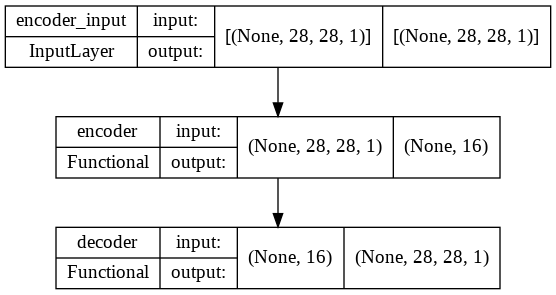

In [4]:
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,   activation='relu',
                        strides=2,
                        padding='same')(x)
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')

autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)



  

In [6]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')
# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=20,
                batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.006

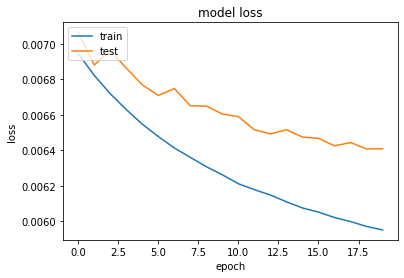

In [7]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

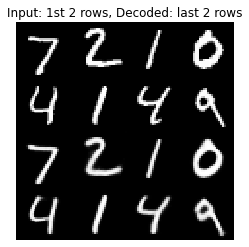

In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()


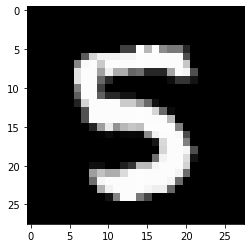

In [ ]:
img = x_test[120].reshape(-1,28,28,1)
plt.imshow(img.reshape(28,28), cmap='gray')

In [ ]:
dec_img = autoencoder.predict(img)

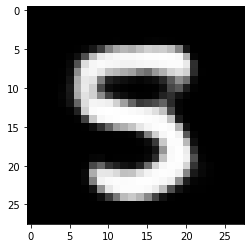

In [ ]:
plt.imshow(dec_img.reshape(28,28), cmap='gray')